In [21]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy

**Dataset Amazon Top 50 Bestselling Books 2009 - 2022**

Il dataset contiene i 50 libri best seller per anno dal 2009 al 2022

In [13]:
book = pd.read_csv('bestsellers.csv') 
book.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17,2009,Non Fiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5,2009,Non Fiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13,2009,Fiction
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2009,Non Fiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4,2009,Fiction


Da una lettura preliminare del dataset attraverso la funzione head possiamo già capire che si potrà lavorare ad esempio sul campo "genre" che assume solo due tipi (fiction e non fiction) e capirne la correlazione con gli anni, le valutazioni ecc. ecc.

Estraiamo informazioni di base sul nostro dataset.

In [14]:
book.describe()

,User Rating,Reviews,Price,Year
count,700.000000,700.000000,700.000000,700.000000
mean,4.639857,19255.195714,12.700000,2015.500000
std,0.218586,23613.443875,9.915162,4.034011
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4987.250000,7.000000,2012.000000
50%,4.700000,10284.000000,11.000000,2015.500000
75%,4.800000,23358.000000,15.000000,2019.000000
max,4.900000,208917.000000,105.000000,2022.000000


Controllo se ci sono colonne con elementi vuoti, come vedremo non ci sono e quindi non dovrò eseguire funzioni di riempimento automatico

In [15]:
book.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

quanti dati e quante caratteristiche abbiamo a disposizione?

In [16]:
book.shape

(700, 7)

Dall'output della funzione shape capiamo che le colonne sono 7 (informazione già conosciuta) e che il numero di righe e cioè libri nel dataset è 700

Adesso calcoliamo la correlazione?

In [17]:
book.corr()

,User Rating,Reviews,Price,Year
User Rating,1.000000,0.080423,-0.157253,0.286601
Reviews,0.080423,1.000000,-0.114554,0.494279
Price,-0.157253,-0.114554,1.000000,-0.155266
Year,0.286601,0.494279,-0.155266,1.000000


Come immaginabile la correlazione tra dati che si nota maggiormente è quella Reviewes - Year e quella User Rating - Year. Questo probabilmente perchè col passare degli anni e con la crescita della popolarità di amazon anche il numero di utenti che lasciano valutazioni e reviews è aumentato.
Di seguito un grafico a linee che dimostra quello appena detto:

In [ ]:
#TODO
"""
features = ['Diameter'] 
x=book[features]
y=book['Rings']

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3)

regressor = LinearRegression()

lin_reg = regressor.fit(X_train, y_train)

print('intercept:',lin_reg.intercept_)
print('coefficient:',lin_reg.coef_)

plt.scatter(X_train,y_train,alpha = 0.2)

y_hat = X_train*lin_reg.coef_ + lin_reg.intercept_
plt.plot(X_train,y_hat,color='aqua' )
 
"""

Guardiamo il dataset rappresentandolo con alcuni grafici:

<BarContainer object of 5 artists>

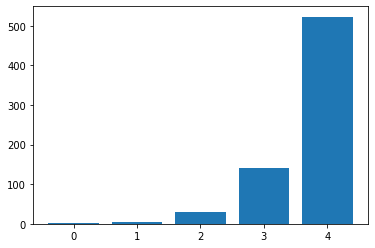

In [18]:
histo = np.histogram(book['User Rating'],bins=5)
plt.bar(x=np.asarray(range(5)),height=histo[0])

Come possiamo immaginare essendo i best-seller degli ultimi anni il grafico mostra che la maggior parte delle valutazioni si avvicinano alle 5 stelle mentre quelle da 2 o 3 stelle sono davvero poche se non inesistenti

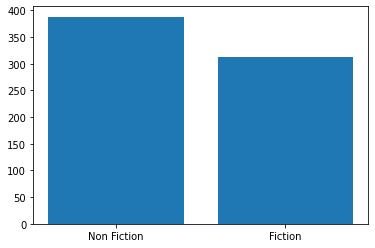

In [19]:
df= pd.DataFrame(book[['Year','Genre']])
counts = df["Genre"].value_counts()
plt.bar(counts.index,counts.values)
plt.show()

[Text(0.5, 1.0, 'user rating by genre')]

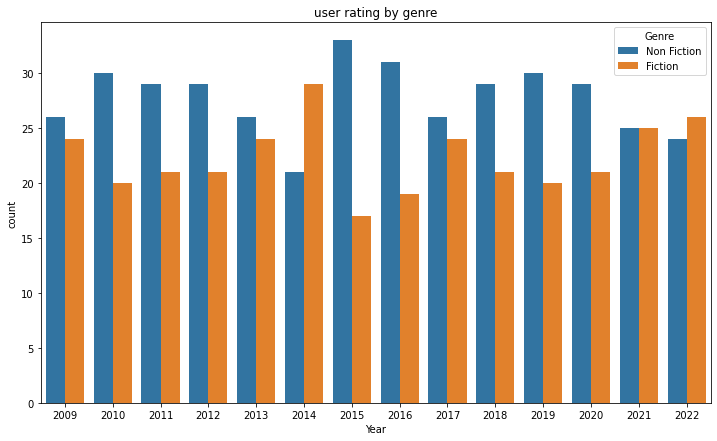

In [22]:
plt.figure(figsize=(12,7))

sns.countplot(x="Year",hue="Genre",data= book).set(title= 'user rating by genre')